# Recitation Course on FEM

# Finite Element Method

In [23]:
# Import packages
import numpy as np

# Create mesh, using GMSH

http://linuxg.net/how-to-install-gmsh-2-8-5-on-the-most-popular-linux-systems/
http://gmsh.info 

Why mesh like that? 
Delaunay triangulation for a given set of discrete points in a plane is a triangulation such that no point is inside the circumcircle of any triangle. Delaunay triangulations maximize the minimum angle of all the angles of the triangles in the triangulation (more https://en.wikipedia.org/wiki/Delaunay_triangulation)

In [24]:
# Load preprocessed .txt files with geometry

# coordinates of all nodes
p = np.loadtxt('nodes_2ref.txt')
# unique triangles defined as the combination of 3 nodes 
t = np.loadtxt('triangles_2ref.txt')

# print
print(p)
print(t)

[[   1.            0.            0.            0.        ]
 [   2.            1.            0.            0.        ]
 [   3.            0.            1.            0.        ]
 ..., 
 [ 527.            0.79227974    0.90715345    0.        ]
 [ 528.            0.81075793    0.8623451     0.        ]
 [ 529.            0.9454054     0.77009422    0.        ]]
[[   1.    2.    2. ...,   87.  184.  185.]
 [   2.    2.    2. ...,  184.   26.  185.]
 [   3.    2.    2. ...,  184.   25.   26.]
 ..., 
 [ 974.    2.    2. ...,  506.  519.  529.]
 [ 975.    2.    2. ...,  506.  181.  519.]
 [ 976.    2.    2. ...,  529.  519.  167.]]


In [25]:
# Some more post-processing 

# since we are modeling the 2D case
p = np.delete(p, 3, 1)  # delete fourth column of p

# deleted collumns are gmsh attributes related with the orientation of the surface that are not relevant in this case
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t
t = np.delete(t, 1, 1)  # delete second column of t

print(p)
print(t)


[[   1.            0.            0.        ]
 [   2.            1.            0.        ]
 [   3.            0.            1.        ]
 ..., 
 [ 527.            0.79227974    0.90715345]
 [ 528.            0.81075793    0.8623451 ]
 [ 529.            0.9454054     0.77009422]]
[[   1.   87.  184.  185.]
 [   2.  184.   26.  185.]
 [   3.  184.   25.   26.]
 ..., 
 [ 974.  506.  519.  529.]
 [ 975.  506.  181.  519.]
 [ 976.  529.  519.  167.]]


In [26]:
# Get the number of nodes and triangles
N = int(p[-1,0])
T = int(t[-1,0])

print(N)
print(T)
np.shape(p)
np.shape(t)

529
976


(976, 4)

### Assembling the matrix

Classical way:

* Notice that $\nabla v_k$ are piecewise constant:
$$
A_{k,\ell}
= \int_{\Omega} \nabla v_k \cdot \nabla v_\ell
= \sum_{T\in\mathcal T} |T| (\nabla v_k|_T) \cdot (\nabla v_\ell|_T),
$$
where $|T|$ is the volume or area of $T$

* Pseudocode:
```
for k = 1 to n
  for l = 1 to n
    for all T
      if(k and l are nodes of T)
      // otherwise the integral is zero
        A(k,l) += |T|
           *(\nabla v_k|_T)
           *(\nabla v_l|_T)
```

* The loops in the algorithm are often reversed:
```
for all T
    for k, vertices of T
        for l, vertices of T
            A(k,l) += <<as before>>
```


* We have
$$
2 |T| = \det \left(
\begin{array}{cc}
x _2 - x _1 & y _2 - y _1 \\
x _3 - x _1 & y _3 - y _1 \\
\end{array}
\right)
$$
Let $T$'s nodes being $n_1$, $n_2$, $n_3$. Denote $\eta_i := v_{n_i}$.
Then it can be shown
$$
\nabla \eta _j = \frac{1}{2|T|}
\left(
\begin{array}{cc}
y _{j+1} - y _{j+2} \\
x _{j+2} - x _{j+1} \\
\end{array}
\right)
$$
Here we mean $(x_4,y_4) = (x_1,y_1)$, $(x_5,y_5) = (x_2,y_2)$

* Pseudocode:
```
for all T
    calculate M
    for k=1..3
        for l=1..3
            A(nodes(k),nodes(l)) += M(k,l)
```


### Assembling the right-hand side (forces)

$$
\int_T f \eta_i \approx f(x_S, y_S) \int_\Omega \eta_i,
$$
where $(x_S,y_S)$ is the center of mass of the triangle. 

* Pseudocode:
```
for all T
  calculate f(xS, yS)
  for k=1..3
    f(nodes(k)) += 1/3 * area(T) * f(xS, yS)
```

### How about boundary conditions?

* pseudocode:
```
A = zero matrix for free nodes
for k = free nodes
    for l = free nodes
        for all T
            <<SAME>>
```
This fills only the needed rows & columns of the matrix, but for convenience the loops in the algorithm are often reversed:

* pseudocode
```
A = zero matrix for all nodes
for all T
    <<SAME>>
remove rows and columns from A corr. to non-free nodes
```

* The **free nodes** are those that are on $\Gamma_2$ in
$$
\begin{align*}
-\Delta u &= 0\qquad\text{on $\Omega$}
\\
u &= 0\qquad\text{on $\Gamma_1$}
\\
u_n &= 0\qquad\text{on $\Gamma_2$}
\end{align*}
$$

* Alternatively, one can **replace** the corresponding row and column by
$$
\begin{pmatrix}
\cdot & 0 & \cdot & \cdot \\
0 & 1 & 0 & 0\\
\cdot & 0 & \cdot & \cdot \\
\cdot & 0 & \cdot & \cdot \\
\end{pmatrix}
$$

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.07064266  0.0577692   0.04591543
  0.0447374   0.05439984  0.02625173  0.01114588  0.05512693  0.07092059
  0.056

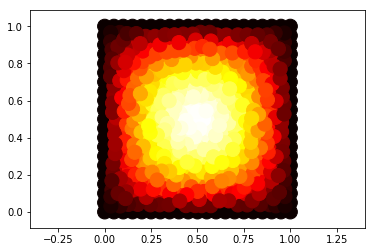

In [10]:
# Solve the simplest problem -Du = 1, Dirichlet boundary conditions

A = np.zeros((N,N))
b = np.zeros(N)

# One big loop for all triangles
for i in range(0,T):
    
    # Extract the vertices of the triangles
    p1 = p[int(t[i,1])-1,1:3] #x1,y1
    p2 = p[int(t[i,2])-1,1:3] #x2,y2
    p3 = p[int(t[i,3])-1,1:3] #x3,y3
    
    verts = np.stack((p1, p2, p3)) # Put vertices into one array
    
    # Find the area of the triangle
    T_area = np.linalg.det([[p2[0]-p1[0],p2[1]-p1[1]],[p3[0]-p1[0],p3[1]-p1[1]]])/2
    
    # Loop for the nodes
    for k in range(0,3):
        for j in range(0,3):
            
            # Index
            k1 = (k+1)%3
            k2 = (k+2)%3
            j1 = (j+1)%3
            j2 = (j+2)%3
            
            # Gradients
            grad1 = np.array([verts[k1,1]-verts[k2,1],verts[k2,0]-verts[k1,0]])
            grad2 = np.array([[verts[j1,1]-verts[j2,1]],[verts[j2,0]-verts[j1,0]]])
            
            # Fill the matrix
            A[int(t[i,j+1])-1,int(t[i,k+1])-1] += 1./(4*T_area)*np.dot(grad1,grad2) 
        
        # Right hand side
        b[int(t[i,k+1])-1] += 1/3*T_area;

# Boundary Conditions
for n in range(0,N):
    if p[n,1] == 0.0 or p[n,2] == 0.0 or p[n,1] == 1.0 or p[n,2] == 1.0:
        A[n,:] = 0
        A[:,n] = 0
        A[n,n] = 1
        b[n] = 0

sol = np.linalg.solve(A, b)
print(sol)

import matplotlib.pyplot as plt
plt.scatter(p[:,1], p[:,2], c=sol,s=200)
plt.axis('equal')
plt.hot()

plt.show()

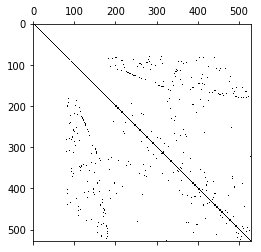

In [15]:
plt.spy(A)
plt.show()